## This Notebook Explore Time Series Analytics and Predictions

#### USAspending.gov GFY Archive Data Source

In [1]:
# recommend creating a conda env for this to use latest version of Prophet
# it should include install of:
# fbprophet (v.7 or newer), dask, pyarrow, fastparquet, plotly, jupyter, ipyfilechooser, ipywidgets (https://ipywidgets.readthedocs.io/en/stable/user_install.html )

In [2]:
import os, glob, pathlib
import math
import shutil
from datetime import datetime
from collections import Counter
import zipfile
import pandas as pd
import numpy as np
# import dask
# import dask.dataframe as dd
# from dask.distributed import Client, progress
import psutil
import requests

import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt

# use import below to interactively select the folder where the USAspending Archives are located
# https://pypi.org/project/ipyfilechooser/
from ipyfilechooser import FileChooser
import random

In [3]:
matplotlib.style.use('seaborn')

In [4]:
def Display_System_Info(): # https://psutil.readthedocs.io/en/latest/#psutil.virtual_memory
    physical_cores = psutil.cpu_count(logical=False) #, psutil.cpu_count(logical=True)
    RAM_total_installed = psutil.virtual_memory()[0] #, psutil.swap_memory()
    RAM_available = psutil.virtual_memory().available #['available']
    dask_workers = int(physical_cores/2)
    print(f"Physical CPU Cores: {physical_cores}, RAM available: {round(RAM_available/1e9)} GB, total RAM: {round(RAM_total_installed/1e9)} GB")
    result_record = {'CPU_Cores_Physical' : physical_cores,
                    'RAM_available' : RAM_available,
                     'RAM_total_installed' : RAM_total_installed,
                    }
    return result_record

Display_System_Info()

Physical CPU Cores: 8, RAM available: 33 GB, total RAM: 69 GB


{'CPU_Cores_Physical': 8,
 'RAM_available': 33314541568,
 'RAM_total_installed': 68719476736}

In [5]:
def Get_Current_Time():
    return datetime.now().strftime("%d/%m/%Y %H:%M:%S")

Get_Current_Time()

'26/10/2020 08:56:20'

In [6]:
def CurrentGFY():
    if datetime.now().month >= 10: 
        return datetime.now().year + 1
    else:
        return datetime.now().year
    
def getGFY(datestamp):
    if datestamp.month >= 10: 
        return datestamp.year + 1
    else:
        return datestamp.year
    
def Check_Archive_Filename_Format(filename_complete):
    base_filename = os.path.basename(filename_complete)
    # rule checks
    if not base_filename.startswith("FY"):
        return False
    if not base_filename.endswith(".zip") and not base_filename.endswith(".csv"):
        return False
    if " " in base_filename:
        return False
    if len(base_filename.split(".")) > 2:
        return False
    if "copy" in base_filename:
        return False
    
    return True

def Get_GFY_from_file_path(filename_to_check_complete_path):
    if os.path.isdir(filename_to_check_complete_path):
        #print(f"{filename_to_check_complete_path} is a directory. Ignore")
        return
    filename_GFY = os.path.basename(filename_to_check_complete_path)[:6]
    assert filename_GFY[:2] == 'FY' # check this
    return filename_GFY

def Get_ArchiveDate_from_file_path(filename_to_check_complete_path):
    if os.path.isdir(filename_to_check_complete_path):
        #print(f"{filename_to_check_complete_path} is a directory. Ignore")
        return
    basefilename = os.path.basename(filename_to_check_complete_path)
    if filename_to_check_complete_path.endswith(".zip"):
        filename_latest_update = basefilename.split("_")[4][0:8]
    elif filename_to_check_complete_path.endswith(".csv"):
        filename_latest_update = basefilename.split("_")[4][0:8]
    else:
        filename_latest_update ="Filename_Format_Issue"
    # assert TBD
    return filename_latest_update

In [7]:
# Clean up the Data and add some fields

### function to create a recipient common name using common fields
### addresses problem with multiple versions of names, M&A, and misspellings

#### Please read this link on the USAspending.gov site about use of "D&B Open Data" - https://www.usaspending.gov/db_info
#### "D&B Open Data" is embedded in these records

#TODO - placeholder function - enhance this to find the most common name for the same company in the records 
def Add_Common_Recipient_Names(df): #placeholder for future data validation using a common key(s) or hash value
    # add transformation and validation code to select most common name for an entity-firm-contractor
    df['recipient_parent_name_common'] = df['recipient_parent_name']
    df['recipient_name_common'] = df['recipient_name']
    return

# !!! possible use in the future cage_codes are missing for most records prior to GFY19
# def Add_Common_Recipient_Names_Using_CAGE_Code(df): #works ok starting in FY19 (missing from ~200M $s in GFY19) but is unreliable prior to that - missing
#     # Build cage_code to recipient_parent_name, recipient_name mapping and collect the most common names
#     # There are naming inconsistencies in the USAspending.gov data for recipient_names
#     # Create code to build a unique identifier that can be used in groupby for recipient_parent_name when there are spelling and naming inconsistencies

#     cage_name_mapping = df[['action_date_fiscal_year','cage_code','recipient_parent_name', 'recipient_name']].drop_duplicates()
#     #cage_name_mapping.shape

#     #TODO add code to properyly handle how the recipient_parent_name and the recipient_name may change across GFY
#     # get the most common recipient_name for each cage_code
#     cage_name_mapping_recipient_parent = cage_name_mapping.groupby(['cage_code'])['recipient_parent_name'].apply(list).apply(Counter).apply(lambda x: x.most_common()[0][0])
#     cage_name_mapping_recipient = cage_name_mapping.groupby(['cage_code'])['recipient_name'].apply(list).apply(Counter).apply(lambda x: x.most_common()[0][0])

#     #cage_name_mapping_recipient_parent['00026'] # assert in FY2019 == 'MMC INTERNATIONAL CORP.'

#     # add a column with the most common recipient_name for downstream groupby actions
#     df['recipient_parent_name_common'] = df['cage_code'].apply(lambda x: cage_name_mapping_recipient_parent[x])
#     df['recipient_name_common'] = df['cage_code'].apply(lambda x: cage_name_mapping_recipient[x])    
#     return df

def Fix_Recipient_Name_UNSPECIFIED(df):
    #fix blank or UNSPECIFIED recipient_parent_names
    
#     fix_UNSPECIFIED_lambda = lambda x: x['recipient_name'] + "_UNSPECIFIED" if x['recipient_parent_name'] in ['', 'UNSPECIFIED'] else x['recipient_parent_name']
#     #pandas.core.frame.DataFrame, dask.dataframe.core.DataFrame
#     if type(df) == dask.dataframe.core.DataFrame:
#         df['recipient_parent_name'] = df.apply(fix_UNSPECIFIED_lambda, axis = 1, meta=('recipient_parent_name', 'object'))
#     else:
#         df['recipient_parent_name'] = df.apply(fix_UNSPECIFIED_lambda, axis = 1)
    
    df['recipient_parent_name'] = df['recipient_parent_name'].mask(df['recipient_parent_name'] == 'UNSPECIFIED', df['recipient_parent_name'] + "_UNSPECIFIED") # use of mask instead of other options - https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.mask

    return

def Fix_Recipient_Names_Known_Issues(df): # MANUAL Fixes needed due to USAspending.gov not updating recipient_parent_name (e.g., after SAIC spun out Leidos)
    #TODO - shoould be added at time of read of the files as part of prep
    
    #fix Naming Issues - Manual Fixes (large firms mostly - edit the external files)
    
    if glob.glob("USAspending_Parent_Name_Fixes_Manual.csv"):
        df_fixes = pd.read_csv("USAspending_Parent_Name_Fixes_Manual.csv")
        manual_fixes_lookup = {}
        for index, row in df_fixes.iterrows():
            manual_fixes_lookup[row['recipient_old_name']] = {'recipient_new_name' :row['recipient_new_name'],
                                                              'GFY_When_Switch_Happens' : row['GFY_When_Switch_Happens'],
                                                             }
    
    else:
        manual_fixes_lookup = {
            'SAIC' : {'recipient_new_name' : 'LEIDOS HOLDINGS  INC.',
                                                               'GFY_When_Switch_Happens' : '2014'}, #!!Notes ther is an extra space needed between HOLDINGS and Inc. name in USAspending, common name fix
            'NORTHROP GRUMMAN SYSTEMS CORPORATION' : {'recipient_new_name' : 'NORTHROP GRUMMAN CORPORATION',
                                                      'GFY_When_Switch_Happens' : ''
                                                     },

        }
    
    for old_name, new_name_record in manual_fixes_lookup.items():
        new_name = new_name_record['recipient_new_name']
        GFY_When_Switch_Happens = new_name_record['GFY_When_Switch_Happens']
        # mask preferred via https://stackoverflow.com/questions/54360549/dask-item-assignment-cannot-use-loc-for-item-assignment
        
        if not math.isnan(GFY_When_Switch_Happens) and GFY_When_Switch_Happens != '':
            selector = (df['recipient_parent_name'] == old_name) & (df['action_date_fiscal_year'].astype('int64') >= int(GFY_When_Switch_Happens))
        else:
            selector = (df['recipient_parent_name'] == old_name)
        
        df['recipient_parent_name'] = df['recipient_parent_name'].mask(selector, new_name) # use of mask instead of other options - https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.mask
        
    return

def Add_PSC_Cat_Fields(df):
    print(f"{Get_Current_Time()} -> adding PSC_Cat field...")
    df['PSC_Cat'] = df['product_or_service_code'].str[:1]
    df['PSC_Cat_2'] = df['product_or_service_code'].str[:2]
    return

def Fix_High_Compensated_Field(df):
    # these fields were read in via pandas as strings (pandas objects), need to convert them to float
    # some of the fields contain text inside of values and some had NaN that was repalced with UNSPECIFIED
    fields_for_float =[
        'highly_compensated_officer_1_amount',
           'highly_compensated_officer_2_amount',
           'highly_compensated_officer_3_amount',
           'highly_compensated_officer_4_amount',
           'highly_compensated_officer_5_amount'
    ]


    for field in fields_for_float:
        df[field] = df[field].apply(lambda x: float(x) if x.replace(".","").isdigit() else 0.0)
    return
    

def Enhance_Spending_File(df): # this function addresses known shortcomings in the USAspending archive data
    print()
    print(f"{Get_Current_Time()} -> replacing NaN with UNSPECIFIED...")
    df = df.fillna("UNSPECIFIED") # IMPORTANT - NA fields can affect groupby sums and other problems
    
    if 'product_or_service_code' in df.columns:
        Add_PSC_Cat_Fields(df)
    
    print(f"{Get_Current_Time()} -> fixing missing recipient_parent_name...")
    Fix_Recipient_Name_UNSPECIFIED(df)
    print(f"{Get_Current_Time()} -> fixing recipient_parent_names that are inconsistent...")
    Fix_Recipient_Names_Known_Issues(df)
    
    #print(f"{Get_Current_Time()} -> adding recipient_name_common and recipient_parent_name_common fields for groupby")
    #Add_Common_Recipient_Names(df)
    
    if 'highly_compensated' in df.columns:
        print(f"{Get_Current_Time()} -> converting highly_compensated field amounts to float")
        Fix_High_Compensated_Field(df)
    
    print(f"{Get_Current_Time()} Done with fixes.")
    print()
    return df

In [8]:
## Key code for read CSV files into pandas and Dask
def Build_DTypes_Dict(filename_list):
    df = pd.read_csv(filename_list[0], nrows=1)
    
    dtype = dict(zip(sorted(df.columns), ['object'] * len(df.columns)))
    
    # ! important - may need to change other fields to category, int, date etc for better memory management
    dtype['federal_action_obligation'] = 'float64'
    #dtype['action_date_fiscal_year'] = 'int'
    
    return dtype

def Load_CSV_Files_Into_DF(filename_list, usecols = 'ALL'): #best approach if you have enough RAM memory on your machine
    
    dtype = Build_DTypes_Dict(filename_list) # ! important - may need to change other fields to category, int, date etc for better memory management
    
#     print(f"Reading file: {filename_list[0]}")
#     df = pd.read_csv(filename_list[0], dtype=dtype, low_memory=False) # read the first file
    
#     for filename in filename_list[1:]: #read the remaining files and append
#         print(f"Reading file: {filename}")
#         df = df.append(pd.read_csv(filename, dtype=dtype, low_memory=False))
        
    #alternative approach - faster?
    dataframe_loads_list = []
    for filename in filename_list:
        print(f"Reading file: {os.path.basename(filename)}")
        if usecols == 'ALL':
            dataframe_loads_list.append(pd.read_csv(filename, dtype=dtype, low_memory=False))
        else:
            dataframe_loads_list.append(pd.read_csv(filename, dtype=dtype, usecols = usecols, low_memory=False))
    df = pd.concat(dataframe_loads_list)
    print("Files loaded into pandas dataframe.")
    return df

In [9]:
# this assumes the jupyter notebook is running in the same higher level directory
# where the USAspending.gov zip archives and the decompressed Zip files are stored

original_cwd = os.getcwd() # use this if  files are located in local directory where jupyter is running
# 
folder_choice = FileChooser(os.getcwd(),
                           title='<b>Choose Folder with USAspending.gov GFY Archive Expanded CSV Files:</b>',
                            show_hidden=False,
                            select_default=True,
                            use_dir_icons=True,
                            show_only_dirs=True)
display(folder_choice)

FileChooser(path='/Users/leifulstrup/Documents/Primehook/Marketing/Medium Blog Posts', filename='', title='HTM…

In [10]:
download_file_path_CSV = str(folder_choice.selected_path)

your_path_dummy = 'Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName'
#print(original_cwd)
print(os.path.join(your_path_dummy, "/".join(download_file_path_CSV.split('/')[-2:])))

Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName/USAspending_Archive_Downloads/Expanded_CSV_Files


In [11]:
# do a quick check to make sure the CSV files are there
csv_files_list = sorted(glob.glob(os.path.join(download_file_path_CSV, "*.csv")))

gfy_list = set()
size_of_files_GB = 0
for n, filename in enumerate(csv_files_list):
    filename_basename = os.path.basename(filename)
    print(n+1, filename_basename)
    gfy_list.add(filename_basename[:6])
    size_of_files_GB += os.path.getsize(filename)

all_GFY_list = sorted(set([Get_GFY_from_file_path(filename) for filename in csv_files_list]))
    
print()
print(f"There are {len(csv_files_list)} CSV files. They use {round(size_of_files_GB/1e9, 3)} GB of storage.")
print(f"Covering GFY: {sorted(gfy_list)}")
print(f"Current GFY: {'FY' + str(CurrentGFY())}")
print()

1 FY2010_All_Contracts_Full_20200807_1.csv
2 FY2010_All_Contracts_Full_20200807_2.csv
3 FY2010_All_Contracts_Full_20200807_3.csv
4 FY2010_All_Contracts_Full_20200807_4.csv
5 FY2011_All_Contracts_Full_20200807_1.csv
6 FY2011_All_Contracts_Full_20200807_2.csv
7 FY2011_All_Contracts_Full_20200807_3.csv
8 FY2011_All_Contracts_Full_20200807_4.csv
9 FY2012_All_Contracts_Full_20200807_1.csv
10 FY2012_All_Contracts_Full_20200807_2.csv
11 FY2012_All_Contracts_Full_20200807_3.csv
12 FY2012_All_Contracts_Full_20200807_4.csv
13 FY2013_All_Contracts_Full_20200807_1.csv
14 FY2013_All_Contracts_Full_20200807_2.csv
15 FY2013_All_Contracts_Full_20200807_3.csv
16 FY2014_All_Contracts_Full_20200808_1.csv
17 FY2014_All_Contracts_Full_20200808_2.csv
18 FY2014_All_Contracts_Full_20200808_3.csv
19 FY2015_All_Contracts_Full_20200808_1.csv
20 FY2015_All_Contracts_Full_20200808_2.csv
21 FY2015_All_Contracts_Full_20200808_3.csv
22 FY2015_All_Contracts_Full_20200808_4.csv
23 FY2015_All_Contracts_Full_20200808_5.c

In [12]:
## Load GFY2010-GFY2019 with limited Columns even though we will mostly use GFY19 (demonstrate usecols feature)

# You can limit the selection to a subset of the GFY to speed processing

ALL_GFY = False # switch to True to override the subset

user_select_GFY = ['FY2020','FY2019', 'FY2018', 'FY2017', 'FY2016', 'FY2015', 'FY2014', 'FY2013', 'FY2012', 'FY2011', 'FY2010']

if ALL_GFY:
    user_select_GFY = all_GFY_list
    
# print(f"GFY to read for analysis: {sorted(user_select_GFY)}")
# print()

# Create csv_files_list_restricted to streamline downstream data processing

csv_files_list = sorted(glob.glob(os.path.join(download_file_path_CSV, "*.csv")))
csv_files_list_restricted = [filename for filename in csv_files_list for GFY in user_select_GFY if GFY in filename]
gfy_found_in_files = [Get_GFY_from_file_path(filename) for filename in csv_files_list_restricted]
csv_GFY_missing = sorted(set(user_select_GFY) - set(gfy_found_in_files))

assert set(user_select_GFY) == set(user_select_GFY) # check to make sure this is working

print(f"You have selected these GFY for analysis:{user_select_GFY}")
print(f"Missing GFY: {csv_GFY_missing} -> if GFY missing, confirm you have decompressed the GFY zip file archive")

#[(os.path.basename(filename), round(os.path.getsize(filename)/1e9, 3)) for filename in csv_files_list_restricted]

You have selected these GFY for analysis:['FY2020', 'FY2019', 'FY2018', 'FY2017', 'FY2016', 'FY2015', 'FY2014', 'FY2013', 'FY2012', 'FY2011', 'FY2010']
Missing GFY: [] -> if GFY missing, confirm you have decompressed the GFY zip file archive


### Select a subset of fields we will use for forecasting

In [294]:
%%time

dtype = Build_DTypes_Dict(csv_files_list_restricted) # this handles reduces ambiguity for dask interpreting data type to infer on read

### Since we only need a few fields from the ~280 fields, we can radically reduce the memory needed and use pandas

fields = sorted(dtype.keys())

CPU times: user 25.5 ms, sys: 2.86 ms, total: 28.4 ms
Wall time: 30.1 ms


In [295]:
#fields

In [296]:
# we do not need all of the 280+ fields from the records
# usecols = in pd.read_csv and Dask allows one to be selective on the fields and save memory

usecols = ['action_date',
           'action_date_fiscal_year',
           'recipient_parent_name',
           'recipient_name',
           'federal_action_obligation',
           'funding_agency_name',
           'funding_sub_agency_name',
           'funding_office_name',
           'product_or_service_code_description',
           'product_or_service_code',
          ]

In [297]:
%%time

USAspending_parquet_file_name = "USAspending_GFY2010_GFY2020ytd_Time_Series_Analytics.parquet"

if glob.glob(USAspending_parquet_file_name): #if this file read has already happened, read from parquet file
    print(f"Reading parquet file: {USAspending_parquet_file_name} instead of CSV file sources.")
    df = pd.read_parquet(USAspending_parquet_file_name)
else:
    df = Load_CSV_Files_Into_DF(csv_files_list_restricted, usecols = usecols)
    df = Enhance_Spending_File(df)
    # Save the data in a parquet file to restart below if needed
    print(f"Saving the data to a parquet file: {USAspending_parquet_file_name} in local directory.")
    df.to_parquet(USAspending_parquet_file_name)
    #df.to_csv("USAspending_GFY2010_GFY2020ytd_Time_Series_Analytics_Fields_Subset.csv", index=False)

df = df.reset_index(drop=True) # creating a new index is key here for later index searches - duplicates otherwise

df.head()

Reading parquet file: USAspending_GFY2010_GFY2020ytd_Time_Series_Analytics.parquet instead of CSV file sources.
CPU times: user 1min 2s, sys: 24.2 s, total: 1min 26s
Wall time: 44.2 s


,federal_action_obligation,action_date,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,funding_office_name,recipient_name,recipient_parent_name,product_or_service_code,product_or_service_code_description,PSC_Cat,PSC_Cat_2
0,0.00,2009-12-15,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W1YN USA MANPOWER ANALYSIS AGY,BOOZ ALLEN HAMILTON INC.,BOOZ ALLEN HAMILTON HOLDING CORPORATION,R499,OTHER PROFESSIONAL SERVICES,R,R4
1,0.00,2010-04-16,2010,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,ALLSTEEL INC.,HNI CORPORATION,7110,OFFICE FURNITURE,7,71
2,840000.00,2009-12-09,2010,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION ...,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,GODDARD SPACE FLIGHT CENTER,THE PENNSYLVANIA STATE UNIVERS,"PENNSYLVANIA STATE UNIVERSITY, THE",AR21,R&D-SPACE SCIENCE & APPL-B RES,A,AR
3,186174.39,2009-12-29,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W1YN USA MANPOWER ANALYSIS AGY,BOOZ ALLEN HAMILTON INC.,BOOZ ALLEN HAMILTON HOLDING CORPORATION,R499,OTHER PROFESSIONAL SERVICES,R,R4
4,0.00,2010-09-15,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,NAVSUP WEAPON SYSTEMS SUPPORT MECH,VELAN INC,SOCIETE HOLDING VELAN LTEE,4820,"VALVES, NONPOWERED",4,48


In [298]:
df.columns

Index(['federal_action_obligation', 'action_date', 'action_date_fiscal_year',
       'funding_agency_name', 'funding_sub_agency_name', 'funding_office_name',
       'recipient_name', 'recipient_parent_name', 'product_or_service_code',
       'product_or_service_code_description', 'PSC_Cat', 'PSC_Cat_2'],
      dtype='object')

In [299]:
assert set(df.columns) - set(usecols) == {'PSC_Cat', 'PSC_Cat_2'} # make sure we retrieved the fields we expected

In [300]:
assert df.shape[0] == len(set(df.index)) #confirm we have created unique index values after append since CSV read will have duplicate index numbers

In [301]:
print(f"There are ~{int(df.shape[0]/1e6)} million transactions in the dataset.")

There are ~46 million transactions in the dataset.


In [302]:
print(f"pandas DataFrame memory usage: ~{round(df.memory_usage().sum()/1e9,1)} GB")

pandas DataFrame memory usage: ~4.4 GB


In [303]:
%time
### If you launch Dask computations but want to stop it, select the square jupyter button "interrupt the kernel"

##This can be used as a QC check to make sure the GFY requested were read
##this is a slow computation since Dask must read every record in all of the files
# action_date_fiscal_yearS = set(sorted(ddf['action_date_fiscal_year'].unique()))
# assert action_date_fiscal_yearS == user_select_GFY

# Without the command .compute() at the end of the next statement, Dask adds the task to a graph of operations.
# when Dask encounters a .compute(), the preceding graph operations are performed

df_GFY_obligations = df.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()

# You can check the computations against these articles:
# https://about.bgov.com/news/federal-contract-spending-five-trends-in-five-charts/
df_GFY_obligations

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


,action_date_fiscal_year,federal_action_obligation
0,2010,5.610369e+11
1,2011,5.398079e+11
2,2012,5.208065e+11
3,2013,4.633853e+11
4,2014,4.461897e+11
5,2015,4.397271e+11
6,2016,4.754231e+11
7,2017,5.105917e+11
8,2018,5.553379e+11
9,2019,5.898982e+11


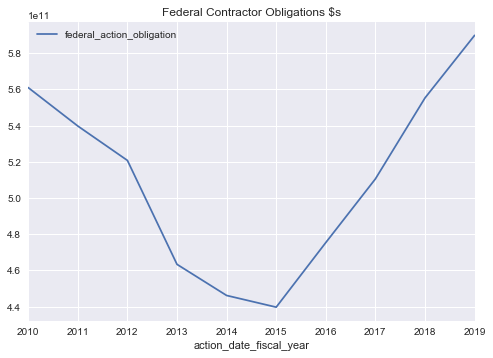

In [304]:
df_GFY_obligations[:-1].plot(x='action_date_fiscal_year', y='federal_action_obligation',title="Federal Contractor Obligations $s",grid=True)

### Collect Information about the Federal Product or Service Code Categories

In [323]:
# retrieve the PSC Codes for reference and reporting purposes
# source my colab notebook and github code - https://github.com/leifulstrup/USAspending_Medium_Blog_Analytics_Series/blob/master/Medium_Analytics_Edge_Open_Data_CMS_Fraud_Contracts_Example-via_Colab.ipynb

url_psc_lookup = 'https://www.acquisition.gov/sites/default/files/manual/PSC_Data_March_2020_Edition.xls' # latest version when coded - may have bene updated - see here https://www.acquisition.gov/psc-manual

# def Cleanup_Category_Text(text): #fixes the typos in the source excel document
#   text = text.strip() # remove preceding and trailing spaces
#   clean_list = []
#   for token in text.split(" "):
#     if token[0] != '&' and not token[1] in ['&', 'T']:
#       clean_list.append(token.capitalize())
#     else:
#       clean_list.append(token)
#   return " ".join(clean_list)

# download the file from the website to read into pandas
r = requests.get(url_psc_lookup, allow_redirects=True)
file_name = "Federal_PSC_Lookup_Codes.xlsx"
with open(file_name, 'wb') as output:
  output.write(r.content)

# !ls -al

xls = pd.ExcelFile(file_name)
df_psc_lookup = pd.read_excel(xls, sheet_name = 1, skiprows=0) #note that there are Excel Sheets for each of the Level 1 Cats with more details
df_psc_lookup.head()
df_PSC_Cat_Lookup = df_psc_lookup[df_psc_lookup['PSC CODE'].str.len() <= 2][['PSC CODE', 'PRODUCT AND SERVICE CODE NAME']].drop_duplicates()
df_PSC_Cat_Lookup.columns = ['PSC_Code', 'Product_and_Service_Code_Name']
df_PSC_Cat_Lookup

,PSC_Code,Product_and_Service_Code_Name
0,10,WEAPONS
26,11,NUCLEAR ORDNANCE
43,12,FIRE CONTROL EQPT.
64,13,AMMUNITION AND EXPLOSIVES
117,14,GUIDED MISSLES
127,15,AIRCRAFT/AIRFRAME STRUCTURE COMPTS
136,16,AIRCRAFT COMPONENTS/ACCESSORIES
154,17,AIRCRAFT LAUNCH/LAND/GROUND HANDLE
172,19,"SHIPS, SMALL CRAFT, PONTOON, DOCKS"
205,20,SHIP AND MARINE EQUIPMENT


In [324]:
df_PSC_Cat_Lookup['PSC_Cat'] = df_PSC_Cat_Lookup['PSC_Code'].str[0]
df_PSC_Cat_Lookup['PSC_Cat_2'] = df_PSC_Cat_Lookup['PSC_Code'].str[:2]
df_PSC_Cat_Lookup

df_PSC_Cat_numerical_codes = df_PSC_Cat_Lookup[~df_PSC_Cat_Lookup['PSC_Cat'].apply(lambda x: x.isalpha())].groupby(["PSC_Cat"])['Product_and_Service_Code_Name'].apply(lambda x: set(x)).apply(sorted).reset_index()
df_PSC_Cat_numerical_codes

,PSC_Cat,Product_and_Service_Code_Name
0,1,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
1,2,"[ENGINE ACCESSORIES, ENGINES AND TURBINES AND ..."
2,3,"[AGRICULTURAL MACHINERY AND EQPT, BEARINGS, CO..."
3,4,"[FIRE/RESCUE/SAFETY; ENVIRO PROTECT, FURNACE/S..."
4,5,"[COMM/DETECT/COHERENT RADIATION, CONSTRUCTION ..."
5,6,"[ALARM, SIGNAL, SECURITY DETECTION, CHEMICALS ..."
6,7,"[ADP EQPT/SOFTWARE/SUPPLIES AND EQPT, BOOKS, M..."
7,8,"[AGRICULTURAL SUPPLIES, BRUSHES, PAINTS, SEALE..."
8,9,"[FUELS, LUBRICANTS, OILS, WAXES, METAL BARS, S..."


In [325]:
df_PSC_Cat_text_codes = df_PSC_Cat_Lookup[df_PSC_Cat_Lookup['PSC_Code'].apply(len) == 1][['PSC_Cat', 'Product_and_Service_Code_Name']].reset_index(drop=True)
df_PSC_Cat_text_codes

,PSC_Cat,Product_and_Service_Code_Name
0,A,RESEARCH AND DEVELOPMENT
1,B,"SPECIAL STUDIES/ANALYSIS, NOT R&D"
2,C,ARCHITECT/ENGINEER SERVICES
3,D,ADP AND TELECOMMUNICATIONS
4,E,PURCHASE OF STRUCTURES/FACILITIES
5,F,NATURAL RESOURCES MANAGEMENT
6,G,SOCIAL SERVICES
7,H,"QUALITY CONTROL, TEST, INSPECTION"
8,J,"MAINT, REPAIR, REBUILD EQUIPMENT"
9,K,MODIFICATION OF EQUIPMENT


In [326]:
df_PSC_lookup_limited = pd.concat([df_PSC_Cat_numerical_codes, df_PSC_Cat_text_codes], axis=0, sort=False)
df_PSC_lookup_limited

,PSC_Cat,Product_and_Service_Code_Name
0,1,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
1,2,"[ENGINE ACCESSORIES, ENGINES AND TURBINES AND ..."
2,3,"[AGRICULTURAL MACHINERY AND EQPT, BEARINGS, CO..."
3,4,"[FIRE/RESCUE/SAFETY; ENVIRO PROTECT, FURNACE/S..."
4,5,"[COMM/DETECT/COHERENT RADIATION, CONSTRUCTION ..."
5,6,"[ALARM, SIGNAL, SECURITY DETECTION, CHEMICALS ..."
6,7,"[ADP EQPT/SOFTWARE/SUPPLIES AND EQPT, BOOKS, M..."
7,8,"[AGRICULTURAL SUPPLIES, BRUSHES, PAINTS, SEALE..."
8,9,"[FUELS, LUBRICANTS, OILS, WAXES, METAL BARS, S..."
0,A,RESEARCH AND DEVELOPMENT


In [327]:
df_PSC_Cat_Lookup = df_PSC_Cat_Lookup.merge(df_PSC_lookup_limited, on='PSC_Cat')
df_PSC_Cat_Lookup

,PSC_Code,Product_and_Service_Code_Name_x,PSC_Cat,PSC_Cat_2,Product_and_Service_Code_Name_y
0,10,WEAPONS,1,10,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
1,11,NUCLEAR ORDNANCE,1,11,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
2,12,FIRE CONTROL EQPT.,1,12,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
3,13,AMMUNITION AND EXPLOSIVES,1,13,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
4,14,GUIDED MISSLES,1,14,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
5,15,AIRCRAFT/AIRFRAME STRUCTURE COMPTS,1,15,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
6,16,AIRCRAFT COMPONENTS/ACCESSORIES,1,16,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
7,17,AIRCRAFT LAUNCH/LAND/GROUND HANDLE,1,17,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
8,19,"SHIPS, SMALL CRAFT, PONTOON, DOCKS",1,19,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
9,20,SHIP AND MARINE EQUIPMENT,2,20,"[ENGINE ACCESSORIES, ENGINES AND TURBINES AND ..."


In [330]:
df_PSC_Cat_Lookup =df_PSC_Cat_Lookup.rename(columns={'Product_and_Service_Code_Name_x' : 'Product_and_Service_Code_Name',
                                  'Product_and_Service_Code_Name_y' : 'Product_and_Service_Code_Name_PSC_Cat',
                                 })
df_PSC_Cat_Lookup

,PSC_Code,Product_and_Service_Code_Name,PSC_Cat,PSC_Cat_2,Product_and_Service_Code_Name_PSC_Cat
0,10,WEAPONS,1,10,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
1,11,NUCLEAR ORDNANCE,1,11,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
2,12,FIRE CONTROL EQPT.,1,12,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
3,13,AMMUNITION AND EXPLOSIVES,1,13,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
4,14,GUIDED MISSLES,1,14,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
5,15,AIRCRAFT/AIRFRAME STRUCTURE COMPTS,1,15,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
6,16,AIRCRAFT COMPONENTS/ACCESSORIES,1,16,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
7,17,AIRCRAFT LAUNCH/LAND/GROUND HANDLE,1,17,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
8,19,"SHIPS, SMALL CRAFT, PONTOON, DOCKS",1,19,"[AIRCRAFT COMPONENTS/ACCESSORIES, AIRCRAFT LAU..."
9,20,SHIP AND MARINE EQUIPMENT,2,20,"[ENGINE ACCESSORIES, ENGINES AND TURBINES AND ..."


In [404]:
df_PSC_Cat_Lookup['Product_and_Service_Code_Name_PSC_Cat'] = df_PSC_Cat_Lookup['Product_and_Service_Code_Name_PSC_Cat'].apply(lambda x: x if type(x) == str else "+".join(x)[:40])
df_PSC_Cat_Lookup_PSC_Cat_only = df_PSC_Cat_Lookup[['PSC_Cat', 'Product_and_Service_Code_Name_PSC_Cat']].drop_duplicates()
df_PSC_Cat_Lookup_PSC_Cat_only['Product_and_Service_Code_Name_PSC_Cat'] = df_PSC_Cat_Lookup_PSC_Cat_only.apply(lambda x: x['PSC_Cat'] + " - " + x['Product_and_Service_Code_Name_PSC_Cat'], axis=1)
df_PSC_Cat_Lookup_PSC_Cat_only

,PSC_Cat,Product_and_Service_Code_Name_PSC_Cat
0,1,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
9,2,2 - ENGINE ACCESSORIES+ENGINES AND TURBINES
17,3,3 - AGRICULTURAL MACHINERY AND EQPT+BEARINGS
26,4,4 - FIRE/RESCUE/SAFETY; ENVIRO PROTECT+FURNA
36,5,5 - COMM/DETECT/COHERENT RADIATION+CONSTRUCT
44,6,"6 - ALARM, SIGNAL, SECURITY DETECTION+CHEMIC"
53,7,7 - ADP EQPT/SOFTWARE/SUPPLIES AND EQPT+BOOK
63,8,"8 - AGRICULTURAL SUPPLIES+BRUSHES, PAINTS, S"
71,9,"9 - FUELS, LUBRICANTS, OILS, WAXES+METAL BAR"
77,A,A - RESEARCH AND DEVELOPMENT


## Federal Product or Service Category (PSC_Cat) Trends Analysis

In [405]:
df.head()

,federal_action_obligation,action_date,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,funding_office_name,recipient_name,recipient_parent_name,product_or_service_code,product_or_service_code_description,PSC_Cat,PSC_Cat_2
0,0.00,2009-12-15,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W1YN USA MANPOWER ANALYSIS AGY,BOOZ ALLEN HAMILTON INC.,BOOZ ALLEN HAMILTON HOLDING CORPORATION,R499,OTHER PROFESSIONAL SERVICES,R,R4
1,0.00,2010-04-16,2010,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,ALLSTEEL INC.,HNI CORPORATION,7110,OFFICE FURNITURE,7,71
2,840000.00,2009-12-09,2010,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION ...,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,GODDARD SPACE FLIGHT CENTER,THE PENNSYLVANIA STATE UNIVERS,"PENNSYLVANIA STATE UNIVERSITY, THE",AR21,R&D-SPACE SCIENCE & APPL-B RES,A,AR
3,186174.39,2009-12-29,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,W1YN USA MANPOWER ANALYSIS AGY,BOOZ ALLEN HAMILTON INC.,BOOZ ALLEN HAMILTON HOLDING CORPORATION,R499,OTHER PROFESSIONAL SERVICES,R,R4
4,0.00,2010-09-15,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,NAVSUP WEAPON SYSTEMS SUPPORT MECH,VELAN INC,SOCIETE HOLDING VELAN LTEE,4820,"VALVES, NONPOWERED",4,48


In [406]:
%%time
df_PSC_Cat_Trends = df.groupby(['action_date_fiscal_year', 'PSC_Cat'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)

df_PSC_Cat_Trends = df_PSC_Cat_Trends.merge(df_GFY_obligations, on='action_date_fiscal_year')
df_PSC_Cat_Trends['Fraction_of_Total_Annual_Spending'] = df_PSC_Cat_Trends['federal_action_obligation_x']/df_PSC_Cat_Trends['federal_action_obligation_y']
df_PSC_Cat_Trends.drop(columns=['federal_action_obligation_y'], inplace=True)
df_PSC_Cat_Trends.rename(columns={'federal_action_obligation_x':'federal_action_obligation'}, inplace=True)
df_PSC_Cat_Trends.head()

CPU times: user 3.17 s, sys: 269 ms, total: 3.44 s
Wall time: 3.44 s


,action_date_fiscal_year,PSC_Cat,federal_action_obligation,Fraction_of_Total_Annual_Spending
0,2020,1,1.056279e+11,0.210941
1,2020,R,6.927870e+10,0.138351
2,2020,A,4.278680e+10,0.085446
3,2020,D,3.601242e+10,0.071917
4,2020,6,3.169954e+10,0.063304


In [407]:
df_PSC_Cat_Trends = df_PSC_Cat_Trends.merge(df_PSC_Cat_Lookup_PSC_Cat_only, on='PSC_Cat')
df_PSC_Cat_Trends

,action_date_fiscal_year,PSC_Cat,federal_action_obligation,Fraction_of_Total_Annual_Spending,Product_and_Service_Code_Name_PSC_Cat
0,2020,1,1.056279e+11,0.210941,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
1,2019,1,1.042024e+11,0.176645,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
2,2018,1,9.821009e+10,0.176847,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
3,2017,1,9.401475e+10,0.184129,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
4,2012,1,8.811756e+10,0.169194,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
5,2016,1,8.693383e+10,0.182856,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
6,2011,1,8.565767e+10,0.158682,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
7,2013,1,8.310591e+10,0.179345,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
8,2010,1,6.688913e+10,0.119224,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT
9,2015,1,6.858305e+10,0.155967,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT


In [408]:
#df_PSC_Cat_Trends.query("action_date_fiscal_year == '2019'")['Fraction_of_Total_Annual_Spending'].cumsum()

In [416]:
sorted(df_PSC_Cat_Trends['Product_and_Service_Code_Name_PSC_Cat'].unique())

['1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT',
 '2 - ENGINE ACCESSORIES+ENGINES AND TURBINES ',
 '3 - AGRICULTURAL MACHINERY AND EQPT+BEARINGS',
 '4 - FIRE/RESCUE/SAFETY; ENVIRO PROTECT+FURNA',
 '5 - COMM/DETECT/COHERENT RADIATION+CONSTRUCT',
 '6 - ALARM, SIGNAL, SECURITY DETECTION+CHEMIC',
 '7 - ADP EQPT/SOFTWARE/SUPPLIES AND EQPT+BOOK',
 '8 - AGRICULTURAL SUPPLIES+BRUSHES, PAINTS, S',
 '9 - FUELS, LUBRICANTS, OILS, WAXES+METAL BAR',
 'A - RESEARCH AND DEVELOPMENT',
 'B - SPECIAL STUDIES/ANALYSIS, NOT R&D',
 'C - ARCHITECT/ENGINEER SERVICES',
 'D - ADP AND TELECOMMUNICATIONS',
 'E - PURCHASE OF STRUCTURES/FACILITIES',
 'F - NATURAL RESOURCES MANAGEMENT',
 'G - SOCIAL SERVICES',
 'H - QUALITY CONTROL, TEST, INSPECTION',
 'J - MAINT, REPAIR, REBUILD EQUIPMENT',
 'K - MODIFICATION OF EQUIPMENT',
 'L - TECHNICAL REPRESENTATIVE SVCS.',
 'M - OPERATION OF GOVT OWNED FACILITY',
 'N - INSTALLATION OF EQUIPMENT',
 'P - SALVAGE SERVICES',
 'Q - MEDICAL SERVICES',
 'R - SUPPORT SVCS (PROF, ADM

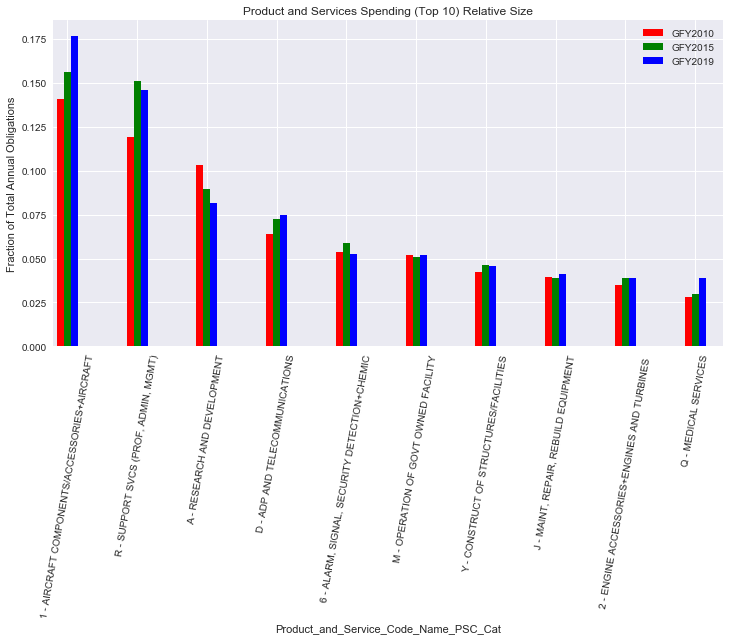

In [503]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure - source - https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis

ax = fig.add_subplot(111) # Create matplotlib axes

width = 0.1
title = "Product and Services Spending (Top 10) Relative Size"
graph1 = df_PSC_Cat_Trends.query("action_date_fiscal_year == '2010'").iloc[:10].sort_values(by='Fraction_of_Total_Annual_Spending', ascending=False).plot(kind="bar", ax=ax,title=title, x='Product_and_Service_Code_Name_PSC_Cat', y='Fraction_of_Total_Annual_Spending', color="red", width=width, align='edge', rot=80, position=2)
graph2 = df_PSC_Cat_Trends.query("action_date_fiscal_year == '2015'").iloc[:10].sort_values(by='Fraction_of_Total_Annual_Spending', ascending=False).plot(kind="bar", ax=ax,title=title, x='Product_and_Service_Code_Name_PSC_Cat', y='Fraction_of_Total_Annual_Spending', color="green", width=width, align='edge', rot=80, position=1)
graph3 = df_PSC_Cat_Trends.query("action_date_fiscal_year == '2019'").iloc[:10].sort_values(by='Fraction_of_Total_Annual_Spending', ascending=False).plot(kind="bar", ax=ax,title=title, x='Product_and_Service_Code_Name_PSC_Cat', y='Fraction_of_Total_Annual_Spending', color="blue", width=width, align='edge', rot=80, position=0)
ax.set_ylabel("Fraction of Total Annual Obligations")
ax.legend(["GFY2010", "GFY2015", "GFY2019"])

In [493]:
psc_cats_all = sorted(df_PSC_Cat_Trends['PSC_Cat'].unique())
gfy_to_include = [str(value) for value in list(range(2010,2020))]
psc_cats_to_include = ['D - ADP AND TELECOMMUNICATIONS', 'R - SUPPORT SVCS (PROF, ADMIN, MGMT)']
#psc_cats_to_include= psc_cats_all
df_PSC_Cat_Trends_plotting_subset = df_PSC_Cat_Trends.query("action_date_fiscal_year in @gfy_to_include & Product_and_Service_Code_Name_PSC_Cat in @psc_cats_to_include")
df_PSC_Cat_Trends_plotting_subset = df_PSC_Cat_Trends_plotting_subset.pivot_table(index='action_date_fiscal_year', values='Fraction_of_Total_Annual_Spending', columns='Product_and_Service_Code_Name_PSC_Cat')
df_PSC_Cat_Trends_plotting_subset

Product_and_Service_Code_Name_PSC_Cat,D - ADP AND TELECOMMUNICATIONS,"R - SUPPORT SVCS (PROF, ADMIN, MGMT)"
action_date_fiscal_year,,
2010,0.053688,0.140503
2011,0.058184,0.144204
2012,0.058712,0.142877
2013,0.063389,0.151607
2014,0.070865,0.146425
2015,0.072703,0.151027
2016,0.072028,0.146428
2017,0.072231,0.145989
2018,0.073158,0.145072


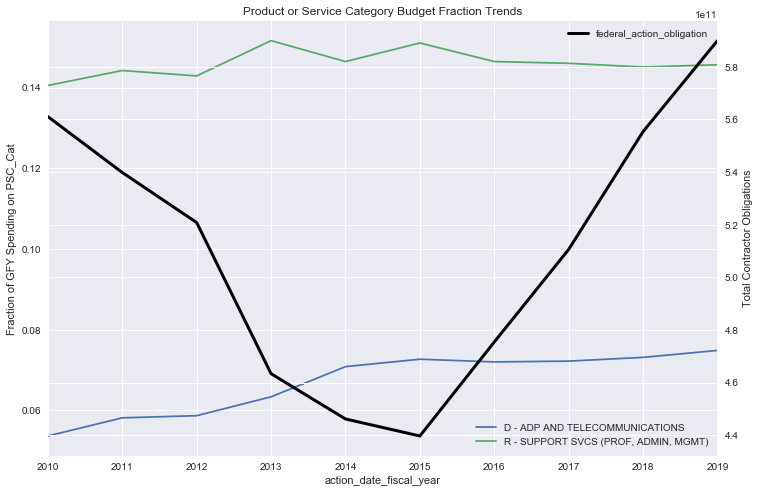

In [513]:
fig = plt.figure(figsize=(12, 8)) # Create matplotlib figure - source - https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() 

graph1 = df_PSC_Cat_Trends_plotting_subset.plot(title='Product or Service Category Budget Fraction Trends', ax=ax)
plt_result = graph1.set_ylabel("Fraction of GFY Spending on PSC_Cat")
plt_result = graph1.legend(loc='center')

graph2 = df_GFY_obligations[:-1].plot(color='black', x='action_date_fiscal_year', y='federal_action_obligation', ax=ax2, linewidth=3)
plt_result = graph2.set_ylabel("Total Contractor Obligations")
plt_result = graph2.legend(loc='upper right')

leg = ax.legend()
leg.remove()
plt_result = ax2.add_artist(leg)

In [461]:
psc_cats_all = sorted(df_PSC_Cat_Trends['Product_and_Service_Code_Name_PSC_Cat'].unique())
gfy_to_include = [str(value) for value in list(range(2010,2020))]
#psc_cats_to_include = ['D - ADP AND TELECOMMUNICATIONS', 'R - SUPPORT SVCS (PROF, ADMIN, MGMT)']
psc_cats_to_include= psc_cats_all
df_PSC_Cat_Trends_plotting_subset = df_PSC_Cat_Trends.query("action_date_fiscal_year in @gfy_to_include & Product_and_Service_Code_Name_PSC_Cat in @psc_cats_to_include")
df_PSC_Cat_Trends_plotting_subset = df_PSC_Cat_Trends_plotting_subset.pivot_table(index='action_date_fiscal_year', values='Fraction_of_Total_Annual_Spending', columns='Product_and_Service_Code_Name_PSC_Cat')
df_PSC_Cat_Trends_plotting_subset_transpose = df_PSC_Cat_Trends_plotting_subset.transpose().reset_index()
#df_PSC_Cat_Trends_plotting_subset_transpose

gfy_columns = [str(value) for value in range(2010,2020)]
df_PSC_Cat_Trends_plotting_subset_transpose = df_PSC_Cat_Trends_plotting_subset_transpose.join(df_PSC_Cat_Trends_plotting_subset_transpose[gfy_columns].agg(['mean','std','max','min'], axis="columns"))
df_PSC_Cat_Trends_plotting_subset_transpose['CAGR_last_3_years'] = df_PSC_Cat_Trends_plotting_subset_transpose.apply(lambda x: -1 + (x['2019']/x['2016'])**(1/3),axis=1)
df_PSC_Cat_Trends_plotting_subset_transpose['2019_vs_2010_delta'] = df_PSC_Cat_Trends_plotting_subset_transpose['2019'] - df_PSC_Cat_Trends_plotting_subset_transpose['2010']
df_PSC_Cat_Trends_plotting_subset_transpose.set_index('Product_and_Service_Code_Name_PSC_Cat', inplace=True)
df_PSC_Cat_Trends_plotting_subset_transpose

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,mean,std,max,min,CAGR_last_3_years,2019_vs_2010_delta
Product_and_Service_Code_Name_PSC_Cat,,,,,,,,,,,,,,,,
1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT,0.119224,0.158682,0.169194,0.179345,0.152746,0.155967,0.182856,0.184129,0.176847,0.176645,0.165564,0.019855,0.184129,0.119224,-0.011453,0.057421
2 - ENGINE ACCESSORIES+ENGINES AND TURBINES,0.052008,0.044848,0.031642,0.026039,0.026530,0.029545,0.029582,0.027635,0.038043,0.039175,0.034505,0.008738,0.052008,0.026039,0.098140,-0.012833
3 - AGRICULTURAL MACHINERY AND EQPT+BEARINGS,0.005089,0.005119,0.005167,0.004519,0.004607,0.004782,0.004360,0.004534,0.004703,0.005495,0.004837,0.000362,0.005495,0.004360,0.080202,0.000407
4 - FIRE/RESCUE/SAFETY; ENVIRO PROTECT+FURNA,0.009941,0.012855,0.013602,0.014272,0.013475,0.014975,0.013773,0.014723,0.016986,0.018289,0.014289,0.002268,0.018289,0.009941,0.099134,0.008348
5 - COMM/DETECT/COHERENT RADIATION+CONSTRUCT,0.042593,0.036330,0.037112,0.036115,0.034517,0.036023,0.037087,0.042425,0.042371,0.042481,0.038705,0.003315,0.042593,0.034517,0.046305,-0.000112
"6 - ALARM, SIGNAL, SECURITY DETECTION+CHEMIC",0.042124,0.045585,0.044575,0.048607,0.052672,0.059086,0.057489,0.056173,0.054674,0.052292,0.051328,0.005833,0.059086,0.042124,-0.031087,0.010168
7 - ADP EQPT/SOFTWARE/SUPPLIES AND EQPT+BOOK,0.027980,0.028394,0.027325,0.025997,0.030877,0.031030,0.031006,0.030128,0.027787,0.027952,0.028848,0.001780,0.031030,0.025997,-0.033974,-0.000028
"8 - AGRICULTURAL SUPPLIES+BRUSHES, PAINTS, S",0.029168,0.031657,0.028742,0.020911,0.018554,0.016094,0.015684,0.017319,0.016817,0.017490,0.021244,0.006158,0.031657,0.015684,0.037014,-0.011678
"9 - FUELS, LUBRICANTS, OILS, WAXES+METAL BAR",0.069534,0.037385,0.049638,0.041948,0.035925,0.029401,0.020481,0.020011,0.020750,0.016381,0.034145,0.016569,0.069534,0.016381,-0.071754,-0.053153


In [462]:
gfy_included_list
df_PSC_Cat_Trends_plotting_subset_transpose.sort_values(by='2019', ascending=False).transpose().loc[gfy_included_list]

Product_and_Service_Code_Name_PSC_Cat,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT,"R - SUPPORT SVCS (PROF, ADMIN, MGMT)",A - RESEARCH AND DEVELOPMENT,D - ADP AND TELECOMMUNICATIONS,"6 - ALARM, SIGNAL, SECURITY DETECTION+CHEMIC",M - OPERATION OF GOVT OWNED FACILITY,Y - CONSTRUCT OF STRUCTURES/FACILITIES,5 - COMM/DETECT/COHERENT RADIATION+CONSTRUCT,"J - MAINT, REPAIR, REBUILD EQUIPMENT",2 - ENGINE ACCESSORIES+ENGINES AND TURBINES,...,"B - SPECIAL STUDIES/ANALYSIS, NOT R&D",K - MODIFICATION OF EQUIPMENT,L - TECHNICAL REPRESENTATIVE SVCS.,N - INSTALLATION OF EQUIPMENT,"H - QUALITY CONTROL, TEST, INSPECTION",W - LEASE/RENT EQUIPMENT,P - SALVAGE SERVICES,X - LEASE/RENT FACILITIES,"T - PHOTO, MAP, PRINT, PUBLICATION",E - PURCHASE OF STRUCTURES/FACILITIES
2010,0.119224,0.140503,0.103381,0.053688,0.042124,0.039563,0.064013,0.042593,0.034831,0.052008,...,0.005946,0.002310,0.003495,0.002553,0.001879,0.001984,0.000862,0.009575,0.000881,0.000169
2011,0.158682,0.144204,0.101467,0.058184,0.045585,0.040776,0.049443,0.036330,0.038635,0.044848,...,0.005934,0.001628,0.003221,0.002251,0.002052,0.001799,0.000632,0.006799,0.000734,0.000032
2012,0.169194,0.142877,0.096260,0.058712,0.044575,0.041685,0.048170,0.037112,0.043648,0.031642,...,0.005426,0.002063,0.003657,0.002158,0.002154,0.001648,0.000892,0.000966,0.000594,0.000072
2013,0.179345,0.151607,0.092668,0.063389,0.048607,0.047828,0.039260,0.036115,0.041686,0.026039,...,0.006055,0.002090,0.002797,0.001881,0.002619,0.001443,0.000853,0.000924,0.000610,0.000034
2014,0.152746,0.146425,0.090689,0.070865,0.052672,0.051826,0.042511,0.034517,0.043859,0.026530,...,0.005864,0.002264,0.002917,0.002351,0.002450,0.001337,0.000912,0.001187,0.000730,0.000039
2015,0.155967,0.151027,0.089280,0.072703,0.059086,0.050653,0.038846,0.036023,0.046179,0.029545,...,0.005719,0.002731,0.002443,0.002430,0.002169,0.001523,0.000887,0.000901,0.000599,0.000040
2016,0.182856,0.146428,0.086026,0.072028,0.057489,0.052454,0.034128,0.037087,0.044985,0.029582,...,0.004968,0.003412,0.003419,0.002016,0.001866,0.001386,0.000829,0.001000,0.000667,0.000046
2017,0.184129,0.145989,0.081863,0.072231,0.056173,0.050502,0.032455,0.042425,0.043862,0.027635,...,0.004722,0.003508,0.003261,0.002384,0.002922,0.001436,0.001085,0.000815,0.000439,0.000105
2018,0.176847,0.145072,0.078367,0.073158,0.054674,0.052443,0.036379,0.042371,0.044280,0.038043,...,0.004546,0.003439,0.003347,0.003803,0.002913,0.001539,0.001203,0.000852,0.000484,0.000043
2019,0.176645,0.145637,0.081282,0.074879,0.052292,0.052011,0.045984,0.042481,0.041333,0.039175,...,0.004843,0.004076,0.003265,0.002793,0.002485,0.001488,0.001206,0.000856,0.000587,0.000009


In [463]:
gfy_included_list = [str(value) for value in range(2010, 2020)]
df_PSC_Cat_Trends_plotting_subset_transpose.sort_values(by='2019', ascending=False).transpose().loc[gfy_included_list]

Product_and_Service_Code_Name_PSC_Cat,1 - AIRCRAFT COMPONENTS/ACCESSORIES+AIRCRAFT,"R - SUPPORT SVCS (PROF, ADMIN, MGMT)",A - RESEARCH AND DEVELOPMENT,D - ADP AND TELECOMMUNICATIONS,"6 - ALARM, SIGNAL, SECURITY DETECTION+CHEMIC",M - OPERATION OF GOVT OWNED FACILITY,Y - CONSTRUCT OF STRUCTURES/FACILITIES,5 - COMM/DETECT/COHERENT RADIATION+CONSTRUCT,"J - MAINT, REPAIR, REBUILD EQUIPMENT",2 - ENGINE ACCESSORIES+ENGINES AND TURBINES,...,"B - SPECIAL STUDIES/ANALYSIS, NOT R&D",K - MODIFICATION OF EQUIPMENT,L - TECHNICAL REPRESENTATIVE SVCS.,N - INSTALLATION OF EQUIPMENT,"H - QUALITY CONTROL, TEST, INSPECTION",W - LEASE/RENT EQUIPMENT,P - SALVAGE SERVICES,X - LEASE/RENT FACILITIES,"T - PHOTO, MAP, PRINT, PUBLICATION",E - PURCHASE OF STRUCTURES/FACILITIES
2010,0.119224,0.140503,0.103381,0.053688,0.042124,0.039563,0.064013,0.042593,0.034831,0.052008,...,0.005946,0.002310,0.003495,0.002553,0.001879,0.001984,0.000862,0.009575,0.000881,0.000169
2011,0.158682,0.144204,0.101467,0.058184,0.045585,0.040776,0.049443,0.036330,0.038635,0.044848,...,0.005934,0.001628,0.003221,0.002251,0.002052,0.001799,0.000632,0.006799,0.000734,0.000032
2012,0.169194,0.142877,0.096260,0.058712,0.044575,0.041685,0.048170,0.037112,0.043648,0.031642,...,0.005426,0.002063,0.003657,0.002158,0.002154,0.001648,0.000892,0.000966,0.000594,0.000072
2013,0.179345,0.151607,0.092668,0.063389,0.048607,0.047828,0.039260,0.036115,0.041686,0.026039,...,0.006055,0.002090,0.002797,0.001881,0.002619,0.001443,0.000853,0.000924,0.000610,0.000034
2014,0.152746,0.146425,0.090689,0.070865,0.052672,0.051826,0.042511,0.034517,0.043859,0.026530,...,0.005864,0.002264,0.002917,0.002351,0.002450,0.001337,0.000912,0.001187,0.000730,0.000039
2015,0.155967,0.151027,0.089280,0.072703,0.059086,0.050653,0.038846,0.036023,0.046179,0.029545,...,0.005719,0.002731,0.002443,0.002430,0.002169,0.001523,0.000887,0.000901,0.000599,0.000040
2016,0.182856,0.146428,0.086026,0.072028,0.057489,0.052454,0.034128,0.037087,0.044985,0.029582,...,0.004968,0.003412,0.003419,0.002016,0.001866,0.001386,0.000829,0.001000,0.000667,0.000046
2017,0.184129,0.145989,0.081863,0.072231,0.056173,0.050502,0.032455,0.042425,0.043862,0.027635,...,0.004722,0.003508,0.003261,0.002384,0.002922,0.001436,0.001085,0.000815,0.000439,0.000105
2018,0.176847,0.145072,0.078367,0.073158,0.054674,0.052443,0.036379,0.042371,0.044280,0.038043,...,0.004546,0.003439,0.003347,0.003803,0.002913,0.001539,0.001203,0.000852,0.000484,0.000043
2019,0.176645,0.145637,0.081282,0.074879,0.052292,0.052011,0.045984,0.042481,0.041333,0.039175,...,0.004843,0.004076,0.003265,0.002793,0.002485,0.001488,0.001206,0.000856,0.000587,0.000009


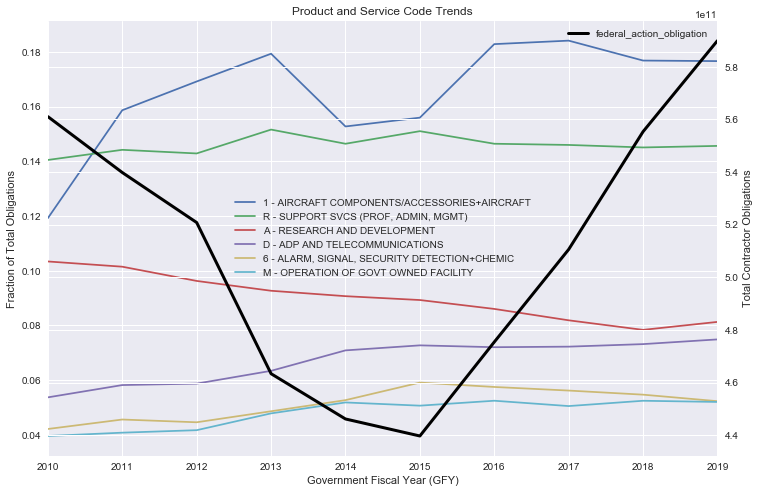

In [510]:
columns_to_include = df_PSC_Cat_Trends_plotting_subset_transpose.sort_values(by='2019', ascending=False).transpose().loc[gfy_included_list].columns[:6]

#df_PSC_Cat_Trends_plotting_subset_transpose.sort_values(by='2019', ascending=False).transpose().loc[gfy_included_list,columns_to_include]

fig = plt.figure(figsize=(12, 8)) # Create matplotlib figure - source - https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() 

graph1 = df_PSC_Cat_Trends_plotting_subset_transpose.sort_values(by='2019', ascending=False).transpose().loc[gfy_included_list,columns_to_include].plot(ax=ax) #plot(ax=ax, position=0)
plt_result = graph1.set_title("Product and Service Code Trends")
plt_result = graph1.set_ylabel("Fraction of Total Obligations")
plt_result = graph1.set_xlabel("Government Fiscal Year (GFY)")
plt_result = graph1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt_result = graph1.legend(loc='center')


graph2 = df_GFY_obligations[:-1].plot(color='black', x='action_date_fiscal_year', y='federal_action_obligation',grid=True, ax=ax2, linewidth=3)
plt_result = graph2.set_ylabel("Total Contractor Obligations")
plt_result = graph2.legend(loc='upper right')

### Explore PSC_Cat D "ADP and Telecommunications" by Department, Agency, and Contractor

In [526]:
%%time
df_PSC_Cat_D = df.query("PSC_Cat == 'D'")
gfy_years = ['2016', '2017', '2018', '2019']
df_PSC_Cat_D = df_PSC_Cat_D.query("action_date_fiscal_year in @gfy_years")

assert set(df_PSC_Cat_D['action_date_fiscal_year'].unique()) == set(gfy_years)

df_PSC_Cat_D.head()

CPU times: user 1.75 s, sys: 74.8 ms, total: 1.83 s
Wall time: 1.8 s


,federal_action_obligation,action_date,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,funding_office_name,recipient_name,recipient_parent_name,product_or_service_code,product_or_service_code_description,PSC_Cat,PSC_Cat_2
19486744,0.00,2016-05-19,2016,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,SUBMEPP ACTIVITY,AMERICAN SYSTEMS CORPORATION,AMERICAN SYSTEMS CORPORATION,D399,IT AND TELECOM- OTHER IT AND TELECOMMUNICATIONS,D,D3
19486771,1028.77,2016-05-19,2016,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,SPACE AND NAVAL WARFARE SYSTEMS,QWEST CORPORATION (8481),CENTURYTEL INC,D304,IT AND TELECOM- TELECOMMUNICATIONS AND TRANSMI...,D,D3
19486782,0.00,2016-07-05,2016,GENERAL SERVICES ADMINISTRATION (GSA),FEDERAL ACQUISITION SERVICE,GSA/FAS CENTER FOR IT SCHEDULE PROG,3T INTERNATIONAL INCORPORATED,3T INTERNATIONAL INC,D301,IT AND TELECOM- FACILITY OPERATION AND MAINTEN...,D,D3
19486793,-6.99,2016-05-06,2016,DEPARTMENT OF DEFENSE (DOD),DEFENSE INFORMATION SYSTEMS AGENCY (DISA),DISA COMPUTING SERVICES LOGISTICS,"DIGITAL MANAGEMENT, INC.",DIGITAL MANAGEMENT INC.,D399,IT AND TELECOM- OTHER IT AND TELECOMMUNICATIONS,D,D3
19486794,5254.40,2016-05-12,2016,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE AIR FORCE,USAF BAND BAL,"COMCAST OF THE DISTRICT, LLC",COMCAST OF THE DISTRICT LLC,D304,IT AND TELECOM- TELECOMMUNICATIONS AND TRANSMI...,D,D3


In [543]:
df_PSC_Cat_D_by_gfy = df_PSC_Cat_D.groupby(["funding_agency_name", "action_date_fiscal_year"])['federal_action_obligation'].sum().fillna(0.0).reset_index()
df_PSC_Cat_D_by_gfy_pivot = df_PSC_Cat_D_by_gfy.pivot_table(index='funding_agency_name', columns='action_date_fiscal_year', values='federal_action_obligation').fillna(0.0).sort_values(by='2019', ascending=False) #.set_index('funding_agency_name')

In [544]:
df_PSC_Cat_D_by_gfy_pivot['CAGR_last_3_years'] = df_PSC_Cat_D_by_gfy_pivot.sort_values(by='2019', ascending=False).apply(lambda x: -1 + (x['2019']/x['2016'])**(1/3) if x['2016'] > 0.0 else 0.0, axis=1)

In [546]:
df_PSC_Cat_D_by_gfy_pivot.head(10)

action_date_fiscal_year,2016,2017,2018,2019,CAGR_last_3_years
funding_agency_name,,,,,
DEPARTMENT OF DEFENSE (DOD),1.419279e+10,1.544899e+10,1.730541e+10,1.903111e+10,0.102720
DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),3.944255e+09,4.300802e+09,4.536467e+09,4.738041e+09,0.063028
DEPARTMENT OF VETERANS AFFAIRS (VA),2.747020e+09,3.211423e+09,3.667341e+09,4.058066e+09,0.138900
DEPARTMENT OF HOMELAND SECURITY (DHS),2.818835e+09,2.964470e+09,3.429618e+09,3.355939e+09,0.059859
DEPARTMENT OF COMMERCE (DOC),9.099136e+08,1.025735e+09,1.113504e+09,1.944038e+09,0.287958
DEPARTMENT OF THE TREASURY (TREAS),1.443714e+09,1.414717e+09,1.520661e+09,1.593741e+09,0.033504
DEPARTMENT OF STATE (DOS),1.139054e+09,1.221536e+09,1.369183e+09,1.272312e+09,0.037568
NATIONAL AERONAUTICS AND SPACE ADMINISTRATION (NASA),8.738106e+08,8.821702e+08,9.686176e+08,1.006878e+09,0.048383
DEPARTMENT OF JUSTICE (DOJ),9.744489e+08,9.924499e+08,1.007365e+09,9.600129e+08,-0.004963


In [609]:
def cagr(v_final, value_initial, years):
    if v_final < 0.0 or value_initial < 0.0: return 0.0
    return -1 + (v_final/value_initial)**(1/years)

assert cagr(2,1,1) == 1.0

In [663]:
# Federal Overall Spending CAGR from GFY16 to GFY19
cagr(df_GFY_obligations[df_GFY_obligations['action_date_fiscal_year'] == '2019']['federal_action_obligation'].iloc[0], df_GFY_obligations[df_GFY_obligations['action_date_fiscal_year'] == '2016']['federal_action_obligation'].iloc[0],3)

0.07456393626678182

In [610]:
cagr_3_year = cagr(df_PSC_Cat_D_by_gfy_pivot['2019'].sum(), df_PSC_Cat_D_by_gfy_pivot['2016'].sum(), 3)
print(f"The three (3) year market CAGR: {round(cagr_3_year, 3)}")
df_PSC_Cat_D_by_gfy_pivot_DoD = df_PSC_Cat_D_by_gfy_pivot.query("funding_agency_name == 'DEPARTMENT OF DEFENSE (DOD)'")
df_PSC_Cat_D_by_gfy_pivot_Civilian = df_PSC_Cat_D_by_gfy_pivot.query("funding_agency_name != 'DEPARTMENT OF DEFENSE (DOD)'")
print(f"The three (3) year market CAGR - DOD: {round(cagr(df_PSC_Cat_D_by_gfy_pivot_DoD['2019'].sum(), df_PSC_Cat_D_by_gfy_pivot_DoD['2016'].sum(), 3), 3)}")
print(f"The three (3) year market CAGR - Civilian: {round(cagr(df_PSC_Cat_D_by_gfy_pivot_Civilian['2019'].sum(), df_PSC_Cat_D_by_gfy_pivot_Civilian['2016'].sum(), 3), 3)}")

The three (3) year market CAGR: 0.089
The three (3) year market CAGR - DOD: 0.103
The three (3) year market CAGR - Civilian: 0.078


In [611]:
selector = (df_PSC_Cat_D_by_gfy_pivot['CAGR_last_3_years'] >= cagr_3_year) & (df_PSC_Cat_D_by_gfy_pivot['2019'] >= 50e6)
df_PSC_Cat_D_by_gfy_pivot[selector].sort_values(by='CAGR_last_3_years', ascending=False)

action_date_fiscal_year,2016,2017,2018,2019,CAGR_last_3_years
funding_agency_name,,,,,
FEDERAL COMMUNICATIONS COMMISSION (FCC),3.071738e+07,4.176287e+07,4.989213e+07,8.292118e+07,0.392389
DEPARTMENT OF COMMERCE (DOC),9.099136e+08,1.025735e+09,1.113504e+09,1.944038e+09,0.287958
DEPARTMENT OF ENERGY (DOE),1.838197e+08,2.147729e+08,2.335146e+08,3.810001e+08,0.275002
ENVIRONMENTAL PROTECTION AGENCY (EPA),1.286408e+08,1.873020e+08,1.971557e+08,2.178190e+08,0.191898
DEPARTMENT OF VETERANS AFFAIRS (VA),2.747020e+09,3.211423e+09,3.667341e+09,4.058066e+09,0.138900
DEPARTMENT OF HOUSING AND URBAN DEVELOPMENT (HUD),2.489829e+08,2.532971e+08,2.493304e+08,3.578170e+08,0.128489
DEPARTMENT OF LABOR (DOL),2.549674e+08,2.895080e+08,3.183197e+08,3.508972e+08,0.112325
DEPARTMENT OF DEFENSE (DOD),1.419279e+10,1.544899e+10,1.730541e+10,1.903111e+10,0.102720


In [612]:
selector = (df_PSC_Cat_D_by_gfy_pivot['CAGR_last_3_years'] < cagr_3_year) & (df_PSC_Cat_D_by_gfy_pivot['2019'] >= 50e6)
df_PSC_Cat_D_by_gfy_pivot[selector].sort_values(by='CAGR_last_3_years', ascending=True)

action_date_fiscal_year,2016,2017,2018,2019,CAGR_last_3_years
funding_agency_name,,,,,
NUCLEAR REGULATORY COMMISSION (NRC),1.261008e+08,1.250368e+08,1.115668e+08,8.769679e+07,-0.114024
NATIONAL ARCHIVES AND RECORDS ADMINISTRATION (NARA),5.761873e+07,5.863024e+07,5.877145e+07,5.317278e+07,-0.026412
AGENCY FOR INTERNATIONAL DEVELOPMENT (USAID),1.398378e+08,1.820302e+08,1.549497e+08,1.348628e+08,-0.012002
DEPARTMENT OF JUSTICE (DOJ),9.744489e+08,9.924499e+08,1.007365e+09,9.600129e+08,-0.004963
NATIONAL SCIENCE FOUNDATION (NSF),9.958151e+07,1.148873e+08,1.001274e+08,9.876719e+07,-0.002733
GENERAL SERVICES ADMINISTRATION (GSA),5.535341e+08,5.543836e+08,4.943173e+08,5.585703e+08,0.003024
EXECUTIVE OFFICE OF THE PRESIDENT (EOP),4.964680e+07,4.269855e+07,6.149803e+07,5.308860e+07,0.022594
SMALL BUSINESS ADMINISTRATION (SBA),6.901367e+07,7.200694e+07,7.751395e+07,7.521248e+07,0.029086
DEPARTMENT OF THE TREASURY (TREAS),1.443714e+09,1.414717e+09,1.520661e+09,1.593741e+09,0.033504


### Which Agencies (below Department level) have seen the greatest PSC_Cat 'D' spending increases?

In [653]:
df_PSC_Cat_D_by_agency = df_PSC_Cat_D.groupby(['action_date_fiscal_year', 'funding_agency_name', 'funding_sub_agency_name'])['federal_action_obligation'].sum().fillna(0.0).reset_index()
df_PSC_Cat_D_by_agency_pivot = df_PSC_Cat_D_by_agency.pivot_table(index=['funding_agency_name','funding_sub_agency_name'], columns='action_date_fiscal_year', values='federal_action_obligation').fillna(0.0).reset_index()
df_PSC_Cat_D_by_agency_pivot['2019_increase_vs_2016'] = df_PSC_Cat_D_by_agency_pivot['2019'] - df_PSC_Cat_D_by_agency_pivot['2016']
df_PSC_Cat_D_by_agency_pivot.sort_values(by='2019_increase_vs_2016', ascending=False).head(10)

action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,2016,2017,2018,2019,2019_increase_vs_2016
261,DEPARTMENT OF VETERANS AFFAIRS (VA),"VETERANS AFFAIRS, DEPARTMENT OF",2.747020e+09,3.211423e+09,3.667341e+09,4.058066e+09,1.311045e+09
95,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE AIR FORCE,2.575150e+09,2.931994e+09,3.497993e+09,3.874446e+09,1.299296e+09
97,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,2.695993e+09,2.962642e+09,3.362551e+09,3.685248e+09,9.892548e+08
85,DEPARTMENT OF DEFENSE (DOD),DEFENSE INFORMATION SYSTEMS AGENCY (DISA),2.001831e+09,1.964323e+09,2.209126e+09,2.716543e+09,7.147120e+08
71,DEPARTMENT OF COMMERCE (DOC),US CENSUS BUREAU,1.586836e+08,2.288406e+08,2.331056e+08,8.107938e+08,6.521102e+08
93,DEPARTMENT OF DEFENSE (DOD),DEPT OF DEFENSE,3.263560e+08,4.378767e+08,6.356977e+08,8.878648e+08,5.615088e+08
83,DEPARTMENT OF DEFENSE (DOD),DEFENSE HEALTH AGENCY (DHA),3.674419e+08,4.801059e+08,5.862088e+08,8.681661e+08,5.007242e+08
119,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,2.078327e+09,2.329850e+09,2.520966e+09,2.566865e+09,4.885374e+08
96,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,4.244320e+09,4.449610e+09,4.802931e+09,4.680623e+09,4.363039e+08
64,DEPARTMENT OF COMMERCE (DOC),NATIONAL OCEANIC AND ATMOSPHERIC ADMINISTRATION,3.856078e+08,4.533112e+08,4.999228e+08,7.931813e+08,4.075736e+08


In [671]:
# the increase in VA PSC_Cat D spending 1.311045e+09 from GFY16-GFY19 is greater than how many Depts

df_PSC_Cat_D_by_gfy_pivot[df_PSC_Cat_D_by_gfy_pivot['2019'] > 1.311045e+09] #.shape[0]

action_date_fiscal_year,2016,2017,2018,2019,CAGR_last_3_years
funding_agency_name,,,,,
DEPARTMENT OF DEFENSE (DOD),1.419279e+10,1.544899e+10,1.730541e+10,1.903111e+10,0.102720
DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),3.944255e+09,4.300802e+09,4.536467e+09,4.738041e+09,0.063028
DEPARTMENT OF VETERANS AFFAIRS (VA),2.747020e+09,3.211423e+09,3.667341e+09,4.058066e+09,0.138900
DEPARTMENT OF HOMELAND SECURITY (DHS),2.818835e+09,2.964470e+09,3.429618e+09,3.355939e+09,0.059859
DEPARTMENT OF COMMERCE (DOC),9.099136e+08,1.025735e+09,1.113504e+09,1.944038e+09,0.287958
DEPARTMENT OF THE TREASURY (TREAS),1.443714e+09,1.414717e+09,1.520661e+09,1.593741e+09,0.033504


In [654]:
df_PSC_Cat_D_by_agency_pivot.sort_values(by='2019_increase_vs_2016', ascending=True).head(10)

action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,2016,2017,2018,2019,2019_increase_vs_2016
147,DEPARTMENT OF HOMELAND SECURITY (DHS),OFFICE OF PROCUREMENT OPERATIONS,5.835729e+08,8.000050e+03,0.000000e+00,1.004949e+06,-5.825679e+08
14,CORPS OF ENGINEERS - CIVIL WORKS (USACE),U.S. ARMY CORPS OF ENGINEERS - CIVIL PROGRAM F...,1.338296e+08,2.014481e+07,1.022684e+08,1.678271e+07,-1.170469e+08
69,DEPARTMENT OF COMMERCE (DOC),PATENT AND TRADEMARK OFFICE,9.844444e+07,0.000000e+00,0.000000e+00,0.000000e+00,-9.844444e+07
157,DEPARTMENT OF HOMELAND SECURITY (DHS),TRANSPORTATION SECURITY ADMINISTRATION,4.495970e+08,3.694887e+08,4.983880e+08,3.563685e+08,-9.322849e+07
25,DEPARTMENT OF AGRICULTURE (USDA),FARM SERVICE AGENCY,1.294448e+08,8.547096e+07,9.750145e+07,4.306576e+07,-8.637905e+07
110,DEPARTMENT OF DEFENSE (DOD),USTRANSCOM,1.423977e+08,1.027057e+08,7.032043e+07,5.727002e+07,-8.512770e+07
174,DEPARTMENT OF JUSTICE (DOJ),FEDERAL BUREAU OF INVESTIGATION,2.944564e+08,3.323344e+08,3.269361e+08,2.310871e+08,-6.336932e+07
276,GENERAL SERVICES ADMINISTRATION (GSA),FEDERAL ACQUISITION SERVICE,3.361595e+08,2.256820e+08,2.313923e+08,2.840046e+08,-5.215485e+07
159,DEPARTMENT OF HOMELAND SECURITY (DHS),U.S. COAST GUARD,2.573947e+08,2.374105e+08,2.626861e+08,2.077875e+08,-4.960718e+07
80,DEPARTMENT OF DEFENSE (DOD),DEFENSE CONTRACT MANAGEMENT AGENCY (DCMA),7.857687e+07,6.488676e+07,3.995174e+07,2.950659e+07,-4.907028e+07


### Which Contractors Have Seen the Greatest Growth and Declines in PSC_Cat 'D' Spending?

In [613]:
df_PSC_Cat_D_by_recipient = df_PSC_Cat_D.groupby(['action_date_fiscal_year', 'recipient_parent_name'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)
df_PSC_Cat_D_by_recipient.head(10)

,action_date_fiscal_year,recipient_parent_name,federal_action_obligation
33230,2019,GENERAL DYNAMICS CORPORATION,2.945345e+09
24983,2018,LEIDOS HOLDINGS INC.,2.836541e+09
34738,2019,LEIDOS HOLDINGS INC.,2.686769e+09
23476,2018,GENERAL DYNAMICS CORPORATION,1.939399e+09
15006,2017,LEIDOS HOLDINGS INC.,1.822033e+09
36226,2019,PERSPECTA INC.,1.789726e+09
5159,2016,LOCKHEED MARTIN CORPORATION,1.651499e+09
30832,2019,BOOZ ALLEN HAMILTON HOLDING CORPORATION,1.592884e+09
22932,2018,ENTERPRISE SERVICES LLC,1.454314e+09
21101,2018,BOOZ ALLEN HAMILTON HOLDING CORPORATION,1.284961e+09


In [635]:
df_PSC_Cat_D_by_recipient_pivot = df_PSC_Cat_D_by_recipient.pivot_table(index='recipient_parent_name', columns='action_date_fiscal_year', values='federal_action_obligation').fillna(0.0).sort_values(by='2019', ascending=False).reset_index()

df_PSC_Cat_D_by_recipient_pivot['CAGR_last_3_years'] = df_PSC_Cat_D_by_recipient_pivot.apply(lambda x: cagr(x['2019'], x['2016'], 3) if x['2016'] > 0.0 else 0.0, axis=1)
df_PSC_Cat_D_by_recipient_pivot['2019_net_increase_vs_2016'] = df_PSC_Cat_D_by_recipient_pivot['2019'] - df_PSC_Cat_D_by_recipient_pivot['2016']
df_PSC_Cat_D_by_recipient_pivot.head(10)

action_date_fiscal_year,recipient_parent_name,2016,2017,2018,2019,CAGR_last_3_years,2019_net_increase_vs_2016
0,GENERAL DYNAMICS CORPORATION,8.407868e+08,8.495516e+08,1.939399e+09,2.945345e+09,0.518740,2.104558e+09
1,LEIDOS HOLDINGS INC.,9.288418e+08,1.822033e+09,2.836541e+09,2.686769e+09,0.424829,1.757927e+09
2,PERSPECTA INC.,0.000000e+00,0.000000e+00,5.163010e+08,1.789726e+09,0.000000,1.789726e+09
3,BOOZ ALLEN HAMILTON HOLDING CORPORATION,9.605553e+08,1.065464e+09,1.284961e+09,1.592884e+09,0.183643,6.323290e+08
4,ACCENTURE INC.,9.866937e+08,1.199114e+09,1.058211e+09,1.179230e+09,0.061220,1.925367e+08
5,NORTHROP GRUMMAN CORPORATION,1.001427e+09,9.599385e+08,9.565770e+08,8.864207e+08,-0.039848,-1.150062e+08
6,VERIZON COMMUNICATIONS INC.,5.773436e+08,6.160577e+08,5.203611e+08,8.146354e+08,0.121613,2.372917e+08
7,CACI INTERNATIONAL INC,5.402945e+08,7.628310e+08,7.762200e+08,8.028504e+08,0.141129,2.625558e+08
8,CERNER GOVERNMENT SERVICES INC.,0.000000e+00,0.000000e+00,4.901866e+08,7.232623e+08,0.000000,7.232623e+08
9,INTERNATIONAL BUSINESS MACHINES CORPORATION,6.386715e+08,6.610066e+08,7.264611e+08,7.179827e+08,0.039790,7.931112e+07


In [636]:
cagr_3_year_all_recipients = cagr(df_PSC_Cat_D_by_recipient_pivot['2019'].sum(), df_PSC_Cat_D_by_recipient_pivot['2016'].sum(), 3)
print(f"The three (3) year CAGR for recipients: {round(cagr_3_year_all_recipients,3)}")

The three (3) year CAGR for recipients: 0.089


In [642]:
selector = (df_PSC_Cat_D_by_recipient_pivot['CAGR_last_3_years'] >= cagr_3_year_all_recipients) & \
(df_PSC_Cat_D_by_recipient_pivot['2019'] >= 50e6)
df_PSC_Cat_D_by_recipient_pivot[selector].sort_values(by='CAGR_last_3_years', ascending=False).head(20)

action_date_fiscal_year,recipient_parent_name,2016,2017,2018,2019,CAGR_last_3_years,2019_net_increase_vs_2016
44,ALL POINTS LOGISTICS INC.,990553.45,30526474.69,1.214986e+08,1.236966e+08,3.998350,1.227061e+08
107,SYNAPTEK CORPORATION,1405514.74,10118351.76,4.275964e+07,6.120834e+07,2.518237,5.980282e+07
59,AFGHAN TELECOM,3793400.98,5765111.96,3.313218e+06,9.468008e+07,1.922424,9.088668e+07
111,CHAGS HEALTH INFORMATION TECHNOLOGY LLC,2588846.83,16630212.99,3.819532e+07,5.946919e+07,1.842684,5.688034e+07
17,CDW CORPORATION,24678419.41,30524754.81,3.657271e+07,4.101398e+08,1.551946,3.854614e+08
133,TRACE SYSTEMS HOLDINGS INC.,3302504.94,7432480.60,2.966055e+07,5.205021e+07,1.507223,4.874771e+07
132,B 3 GROUP INC,3361986.61,49958924.95,5.246875e+07,5.245671e+07,1.498820,4.909472e+07
138,HMS TECHNOLOGIES INC.,3554485.38,51053042.70,5.120238e+07,5.012858e+07,1.416033,4.657409e+07
106,SEMANTICBITS LLC,4961820.08,32620122.01,4.511413e+07,6.200458e+07,1.320568,5.704275e+07
130,FRONTIER TECHNOLOGY INC.,4283398.55,21335517.12,6.894023e+07,5.270876e+07,1.308685,4.842536e+07


In [645]:
df_PSC_Cat_D_by_recipient_pivot.sort_values(by='2019_net_increase_vs_2016', ascending=False).head(10)

action_date_fiscal_year,recipient_parent_name,2016,2017,2018,2019,CAGR_last_3_years,2019_net_increase_vs_2016
0,GENERAL DYNAMICS CORPORATION,8.407868e+08,8.495516e+08,1.939399e+09,2.945345e+09,0.518740,2.104558e+09
2,PERSPECTA INC.,0.000000e+00,0.000000e+00,5.163010e+08,1.789726e+09,0.000000,1.789726e+09
1,LEIDOS HOLDINGS INC.,9.288418e+08,1.822033e+09,2.836541e+09,2.686769e+09,0.424829,1.757927e+09
8,CERNER GOVERNMENT SERVICES INC.,0.000000e+00,0.000000e+00,4.901866e+08,7.232623e+08,0.000000,7.232623e+08
3,BOOZ ALLEN HAMILTON HOLDING CORPORATION,9.605553e+08,1.065464e+09,1.284961e+09,1.592884e+09,0.183643,6.323290e+08
10,RAYTHEON COMPANY,2.110464e+08,2.638219e+08,4.675225e+08,6.815785e+08,0.478130,4.705320e+08
17,CDW CORPORATION,2.467842e+07,3.052475e+07,3.657271e+07,4.101398e+08,1.551946,3.854614e+08
15,SAIC INC.,1.835527e+08,2.085889e+08,2.261407e+08,4.755042e+08,0.373403,2.919515e+08
13,DENALI HOLDING INC,2.250414e+08,4.100633e+08,3.774999e+08,4.877270e+08,0.294111,2.626856e+08
7,CACI INTERNATIONAL INC,5.402945e+08,7.628310e+08,7.762200e+08,8.028504e+08,0.141129,2.625558e+08


In [640]:
selector = (df_PSC_Cat_D_by_recipient_pivot['CAGR_last_3_years'] >= cagr_3_year_all_recipients) & \
(df_PSC_Cat_D_by_recipient_pivot['2019'] >= 350e6)
df_PSC_Cat_D_by_recipient_pivot[selector].sort_values(by='CAGR_last_3_years', ascending=False)

action_date_fiscal_year,recipient_parent_name,2016,2017,2018,2019,CAGR_last_3_years,2019_net_increase_vs_2016
17,CDW CORPORATION,2.467842e+07,3.052475e+07,3.657271e+07,4.101398e+08,1.551946,3.854614e+08
0,GENERAL DYNAMICS CORPORATION,8.407868e+08,8.495516e+08,1.939399e+09,2.945345e+09,0.518740,2.104558e+09
18,JACOBS ENGINEERING GROUP INC.,1.017714e+08,9.932100e+07,2.830946e+08,3.529181e+08,0.513617,2.511466e+08
10,RAYTHEON COMPANY,2.110464e+08,2.638219e+08,4.675225e+08,6.815785e+08,0.478130,4.705320e+08
1,LEIDOS HOLDINGS INC.,9.288418e+08,1.822033e+09,2.836541e+09,2.686769e+09,0.424829,1.757927e+09
15,SAIC INC.,1.835527e+08,2.085889e+08,2.261407e+08,4.755042e+08,0.373403,2.919515e+08
13,DENALI HOLDING INC,2.250414e+08,4.100633e+08,3.774999e+08,4.877270e+08,0.294111,2.626856e+08
14,CGI TECHNOLOGIES AND SOLUTIONS INC.,2.851329e+08,3.594339e+08,4.034159e+08,4.774888e+08,0.187514,1.923559e+08
3,BOOZ ALLEN HAMILTON HOLDING CORPORATION,9.605553e+08,1.065464e+09,1.284961e+09,1.592884e+09,0.183643,6.323290e+08
7,CACI INTERNATIONAL INC,5.402945e+08,7.628310e+08,7.762200e+08,8.028504e+08,0.141129,2.625558e+08


In [633]:
# selector = (df_PSC_Cat_D_by_recipient_pivot['CAGR_last_3_years'] < cagr_3_year_all_recipients) & (df_PSC_Cat_D_by_recipient_pivot['2019'] >= 350e6)
# df_PSC_Cat_D_by_recipient_pivot[selector].sort_values(by='CAGR_last_3_years', ascending=True)

### End

#### https://opensource.org/licenses/MIT

#### MIT Open Source License Copyright 2020 Leif C Ulstrup

#### Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

#### The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

#### THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.